# Description

Runs k-means on the pca version of the data.

# Environment variables

In [1]:
from IPython.display import display

import conf

N_JOBS = conf.GENERAL["N_JOBS"]
display(N_JOBS)

3

In [2]:
%env MKL_NUM_THREADS=$N_JOBS
%env OPEN_BLAS_NUM_THREADS=$N_JOBS
%env NUMEXPR_NUM_THREADS=$N_JOBS
%env OMP_NUM_THREADS=$N_JOBS

env: MKL_NUM_THREADS=3
env: OPEN_BLAS_NUM_THREADS=3
env: NUMEXPR_NUM_THREADS=3
env: OMP_NUM_THREADS=3


# Modules loading

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from pathlib import Path

import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
import seaborn as sns

from utils import generate_result_set_name

# Settings

In [5]:
INITIAL_RANDOM_STATE = 10000

## Input data

In [6]:
INPUT_SUBSET = "pca"

In [7]:
INPUT_STEM = "z_score_std-projection-smultixcan-efo_partial-mashr-zscores"

In [8]:
DR_OPTIONS = {
    "n_components": 50,
    "svd_solver": "full",
    "random_state": 0,
}

In [9]:
input_filepath = Path(
    conf.RESULTS["DATA_TRANSFORMATIONS_DIR"],
    INPUT_SUBSET,
    generate_result_set_name(
        DR_OPTIONS, prefix=f"{INPUT_SUBSET}-{INPUT_STEM}-", suffix=".pkl"
    ),
).resolve()
display(input_filepath)

assert input_filepath.exists(), "Input file does not exist"

input_filepath_stem = input_filepath.stem
display(input_filepath_stem)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base/results/data_transformations/pca/pca-z_score_std-projection-smultixcan-efo_partial-mashr-zscores-n_components_50-random_state_0-svd_solver_full.pkl')

'pca-z_score_std-projection-smultixcan-efo_partial-mashr-zscores-n_components_50-random_state_0-svd_solver_full'

## Clustering

In [10]:
from sklearn.cluster import KMeans

In [11]:
CLUSTERING_ATTRIBUTES_TO_SAVE = ["n_clusters"]

In [12]:
CLUSTERING_OPTIONS = {}

CLUSTERING_OPTIONS["K_MIN"] = 2
CLUSTERING_OPTIONS["K_MAX"] = 60  # sqrt(3749)
CLUSTERING_OPTIONS["N_REPS_PER_K"] = 5
CLUSTERING_OPTIONS["KMEANS_N_INIT"] = 10

display(CLUSTERING_OPTIONS)

{'K_MIN': 2, 'K_MAX': 60, 'N_REPS_PER_K': 5, 'KMEANS_N_INIT': 10}

In [13]:
CLUSTERERS = {}

idx = 0
random_state = INITIAL_RANDOM_STATE

for k in range(CLUSTERING_OPTIONS["K_MIN"], CLUSTERING_OPTIONS["K_MAX"] + 1):
    for i in range(CLUSTERING_OPTIONS["N_REPS_PER_K"]):
        clus = KMeans(
            n_clusters=k,
            n_init=CLUSTERING_OPTIONS["KMEANS_N_INIT"],
            random_state=random_state,
        )

        method_name = type(clus).__name__
        CLUSTERERS[f"{method_name} #{idx}"] = clus

        random_state = random_state + 1
        idx = idx + 1

In [14]:
display(len(CLUSTERERS))

295

In [15]:
_iter = iter(CLUSTERERS.items())
display(next(_iter))
display(next(_iter))

('KMeans #0', KMeans(n_clusters=2, random_state=10000))

('KMeans #1', KMeans(n_clusters=2, random_state=10001))

In [16]:
clustering_method_name = method_name
display(clustering_method_name)

'KMeans'

## Output directory

In [17]:
# output dir for this notebook
RESULTS_DIR = Path(
    conf.RESULTS["CLUSTERING_RUNS_DIR"],
    f"{INPUT_SUBSET}-{INPUT_STEM}",
).resolve()
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

display(RESULTS_DIR)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base/results/clustering/runs/pca-z_score_std-projection-smultixcan-efo_partial-mashr-zscores')

# Load input file

In [18]:
data = pd.read_pickle(input_filepath)

In [19]:
data.shape

(3749, 50)

In [20]:
data.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,...,PCA41,PCA42,PCA43,PCA44,PCA45,PCA46,PCA47,PCA48,PCA49,PCA50
100001_raw-Food_weight,-0.547515,-0.007250,0.245361,0.132424,1.201447,-0.113158,0.048859,1.031679,0.711208,0.126100,...,0.113685,-0.109753,0.178202,-0.487868,1.805920,-0.342611,-0.663712,-1.313987,-1.481707,0.396410
100002_raw-Energy,-1.570593,-0.618992,-1.223395,1.627321,-0.563860,0.224922,-1.500327,2.045633,-1.665998,-0.180432,...,0.697880,1.412676,2.103988,0.385625,2.386495,-2.939998,-0.978275,-1.893307,-0.259497,0.423264
100003_raw-Protein,-0.601212,-0.948824,-1.022209,2.438433,-2.062235,0.356202,-1.538038,2.314675,-1.108991,0.318034,...,0.171992,1.351979,0.054404,-0.725132,2.226520,-3.481674,-0.445294,-0.477452,0.237157,1.440867
100004_raw-Fat,-1.648214,-0.342042,-0.270189,1.683268,-1.222401,0.018349,-0.032824,1.671161,-0.908965,0.224100,...,-0.358812,0.696836,1.072624,0.627951,1.802000,0.174704,0.826319,-0.826992,0.596113,0.620050
100005_raw-Carbohydrate,-1.867586,-0.006412,-0.303220,0.770958,-0.116822,0.460946,-2.407732,1.534273,-1.930577,0.064621,...,1.332852,1.978032,2.158456,0.831123,1.093202,-3.539033,-0.831862,-0.842298,-0.723072,0.359438


In [21]:
assert not data.isna().any().any()

# Clustering

## Generate ensemble

In [22]:
from clustering.ensemble import generate_ensemble

In [23]:
ensemble = generate_ensemble(
    data,
    CLUSTERERS,
    attributes=CLUSTERING_ATTRIBUTES_TO_SAVE,
)

100%|██████████| 295/295 [05:52<00:00,  1.19s/it]


In [24]:
# the number should be close to 295 (the number of partitions generated by k-means/spectral clustering)
ensemble.shape

(295, 3)

In [25]:
ensemble.head()

,clusterer_params,partition,n_clusters
clusterer_id,,,
KMeans #0,"{'algorithm': 'auto', 'copy_x': True, 'init': ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
KMeans #1,"{'algorithm': 'auto', 'copy_x': True, 'init': ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
KMeans #2,"{'algorithm': 'auto', 'copy_x': True, 'init': ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
KMeans #3,"{'algorithm': 'auto', 'copy_x': True, 'init': ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
KMeans #4,"{'algorithm': 'auto', 'copy_x': True, 'init': ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2


In [26]:
ensemble["n_clusters"].value_counts().head()

60    5
16    5
28    5
27    5
26    5
Name: n_clusters, dtype: int64

In [27]:
ensemble_stats = ensemble["n_clusters"].describe()
display(ensemble_stats)

count    295.000000
mean      31.000000
std       17.058323
min        2.000000
25%       16.000000
50%       31.000000
75%       46.000000
max       60.000000
Name: n_clusters, dtype: float64

## Testing

In [28]:
assert ensemble_stats["min"] > 1

In [29]:
assert not ensemble["n_clusters"].isna().any()

In [30]:
assert ensemble.shape[0] == len(CLUSTERERS)

In [31]:
# all partitions have the right size
assert np.all(
    [part["partition"].shape[0] == data.shape[0] for idx, part in ensemble.iterrows()]
)

In [32]:
# no partition has negative clusters (noisy points)
assert not np.any([(part["partition"] < 0).any() for idx, part in ensemble.iterrows()])

## Save

In [33]:
output_filename = Path(
    RESULTS_DIR,
    generate_result_set_name(
        CLUSTERING_OPTIONS,
        prefix=f"{clustering_method_name}-",
        suffix=".pkl",
    ),
).resolve()
display(output_filename)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base/results/clustering/runs/pca-z_score_std-projection-smultixcan-efo_partial-mashr-zscores/KMeans-KMEANS_N_INIT_10-K_MAX_60-K_MIN_2-N_REPS_PER_K_5.pkl')

In [34]:
ensemble.to_pickle(output_filename)

# Stability

## Group ensemble by n_clusters

In [35]:
parts = ensemble.groupby("n_clusters").apply(
    lambda x: np.concatenate(x["partition"].apply(lambda x: x.reshape(1, -1)), axis=0)
)

In [36]:
parts.head()

n_clusters
2    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
3    [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...
4    [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...
5    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
6    [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...
dtype: object

In [37]:
assert np.all(
    [
        parts.loc[k].shape == (CLUSTERING_OPTIONS["N_REPS_PER_K"], data.shape[0])
        for k in parts.index
    ]
)

## Compute stability

In [38]:
from sklearn.metrics import adjusted_rand_score as ari
from scipy.spatial.distance import squareform, pdist

In [39]:
parts_ari = pd.Series(
    {k: pdist(parts.loc[k], metric=ari) for k in parts.index}, name="k"
)

In [40]:
parts_ari_stability = parts_ari.apply(lambda x: x.mean())
display(parts_ari_stability.sort_values(ascending=False).head(15))

2     1.000000
4     0.998132
3     0.993598
5     0.983751
6     0.969448
7     0.963893
9     0.937197
10    0.923767
11    0.913798
8     0.854730
13    0.842554
16    0.828863
14    0.653496
12    0.607263
15    0.510900
Name: k, dtype: float64

In [41]:
parts_ari_df = pd.DataFrame.from_records(parts_ari.tolist()).set_index(
    parts_ari.index.copy()
)

In [42]:
parts_ari_df.shape

(59, 10)

In [43]:
assert (
    int(
        (CLUSTERING_OPTIONS["N_REPS_PER_K"] * (CLUSTERING_OPTIONS["N_REPS_PER_K"] - 1))
        / 2
    )
    == parts_ari_df.shape[1]
)

In [44]:
parts_ari_df.head()

,0,1,2,3,4,5,6,7,8,9
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000
3,0.989330,1.000000,1.000000,0.989330,0.989330,0.98933,1.000000,1.000000,0.989330,0.989330
4,1.000000,0.997001,1.000000,0.996829,0.997001,1.00000,0.996829,0.997001,0.999826,0.996829
5,0.999967,0.965204,0.999967,0.988705,0.965179,1.00000,0.988698,0.965179,0.975909,0.988698
6,0.928658,0.926795,0.932134,0.932060,0.997446,0.99461,0.994498,0.994140,0.994251,0.999888


## Save

In [45]:
output_filename = Path(
    RESULTS_DIR,
    generate_result_set_name(
        CLUSTERING_OPTIONS,
        prefix=f"{clustering_method_name}-stability-",
        suffix=".pkl",
    ),
).resolve()
display(output_filename)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base/results/clustering/runs/pca-z_score_std-projection-smultixcan-efo_partial-mashr-zscores/KMeans-stability-KMEANS_N_INIT_10-K_MAX_60-K_MIN_2-N_REPS_PER_K_5.pkl')

In [46]:
parts_ari_df.to_pickle(output_filename)

## Stability plot

In [47]:
parts_ari_df_plot = (
    parts_ari_df.stack()
    .reset_index()
    .rename(columns={"level_0": "k", "level_1": "idx", 0: "ari"})
)

In [48]:
parts_ari_df_plot.dtypes

k        int64
idx      int64
ari    float64
dtype: object

In [49]:
parts_ari_df_plot.head()

,k,idx,ari
0,2,0,1.0
1,2,1,1.0
2,2,2,1.0
3,2,3,1.0
4,2,4,1.0


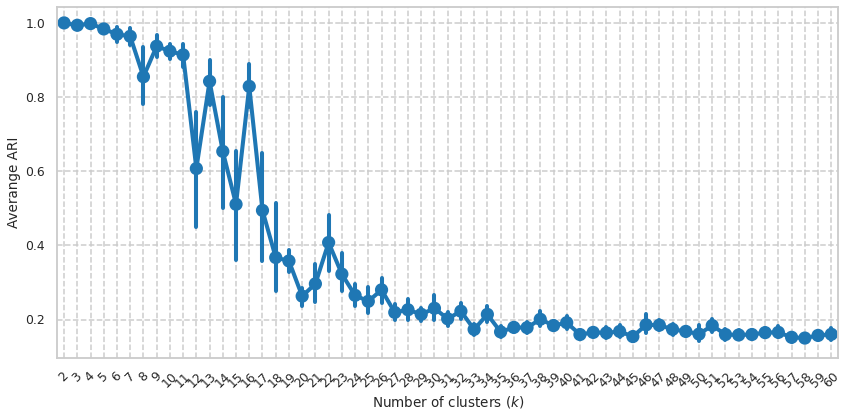

In [50]:
# with sns.axes_style('whitegrid', {'grid.linestyle': '--'}):
with sns.plotting_context("talk", font_scale=0.75), sns.axes_style(
    "whitegrid", {"grid.linestyle": "--"}
):
    fig = plt.figure(figsize=(12, 6))
    ax = sns.pointplot(data=parts_ari_df_plot, x="k", y="ari")
    ax.set_ylabel("Averange ARI")
    ax.set_xlabel("Number of clusters ($k$)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    #     ax.set_ylim(0.0, 1.0)
    #     ax.set_xlim(CLUSTERING_OPTIONS['K_MIN'], CLUSTERING_OPTIONS['K_MAX'])
    plt.grid(True)
    plt.tight_layout()